In [1]:
import time
start = time.time()
#importar datos y librerias
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import signal
import sklearn
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from scipy.stats import boxcox
from scipy import special
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import Ridge
from scipy.ndimage.interpolation import shift
from sklearn.linear_model import Ridge
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import linear_model

In [43]:
def Mape(y,y_pred,sample_weight):
    return np.mean(np.abs((y-y_pred)/y))*100

def isFestivo(x):
    if x:
        return .5
    else:
        return 0
    
def isFestivo1(x):
    if (np.datetime64(x) in festivos.values):
        return 1
    else:
        return 0

def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

def triangular(x, a, b, c):
    return max( min( (x-a)/(b-a), (c-x)/(c-b) ), 0 )
U = np.arange(1,365)

In [44]:
festivos=pd.read_excel("festivos.xlsx")
festivos2=pd.read_excel("festivos2.xlsx")
clima=pd.read_excel("Consumo.xlsx",index_col=0)
consumo=pd.read_excel("Data1.xlsx").drop("Unnamed: 2",axis=1)
consumo1=pd.read_excel("Data1.xlsx").drop("Unnamed: 2",axis=1)
consumo1["fecha1"]=consumo.fecha.copy()
consumo1=consumo1.set_index("fecha")

for column in festivos.columns:
    festivos[column] = pd.to_datetime(festivos[column])
for col in festivos.columns:
    consumo1[col] = consumo1.index.isin(festivos[col])
    consumo1[col]=consumo1[col].apply(isFestivo)
    clean=consumo1[col].values
    consumo1[col]=consumo1[col]+shift(clean, 1, cval=0)*.2
    consumo1[col]=consumo1[col]+shift(clean, -1, cval=0)*.2
    consumo1[col]=consumo1[col]+shift(clean, 2, cval=0)*.05
    consumo1[col]=consumo1[col]+shift(clean, -2, cval=0)*.05
    
consumo1["min"]=clima["mín"].copy()
consumo1["max"]=clima["max"].copy()
consumo1["ones"]=1
consumo1["week"]=consumo1.fecha1.dt.week
consumo1["month"]=consumo1.fecha1.apply(lambda x:x.month)
consumo1["day"]=consumo1.fecha1.dt.weekday
consumo1["lluvia"]=clima.Lluvia.copy()
consumo1["Velocidad"]=clima["Velocidad viento"].copy()
consumo1["Nubosidad"]=clima.Nubosidad.copy()
consumo1["num"]=np.arange(0,len(consumo1.index))+1
consumo1["festivo"]=consumo1.fecha1.apply(isFestivo1)
consumo1.tail()

consumo1["eureka1"]=consumo1.week*consumo1.Nubosidad
consumo1["eureka2"]=consumo1.day**3
consumo1["eureka3"]=consumo1["max"]*consumo1.num

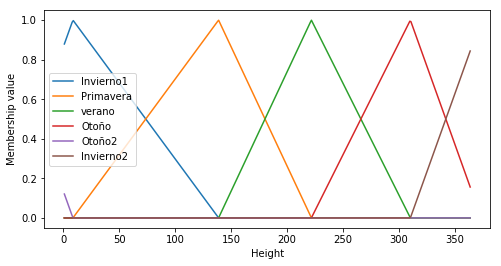

In [45]:
height = {
    'Invierno1': [310.5-365.25, 8.6529, 138.941176470588],
  'Primavera': [8.6529, 138.941176470588, 221.9375],
  'verano': [138.941176470588, 221.9375, 310.5],
  'Otoño': [221.9375, 310.5, 365.25+8.6529],
    'Otoño2': [221.9375-365.25, 310.5-365.25, 8.6529],
  'Invierno2': [310.5, 365.25+8.6529, 365.25+138.941176470588],
}


plt.figure(figsize=(8,4))
lines = []
for fuzzy_set in height.keys():
    memberships = [ triangular(x, *height[fuzzy_set]) for x in U ]
    # plot the chart
    tmp, = plt.plot(U, memberships, label=fuzzy_set)
    lines.append(tmp)
plt.legend(handles=lines)
plt.xlabel("Height")
plt.ylabel("Membership value")
plt.show()
x=[dia%max(U) for dia in range(1,len(consumo.MWh)+1)]


datos=pd.DataFrame()
for element in x:
    l=[]    
    for fuzzy_set in height.keys():
        p=triangular(element, *height[fuzzy_set])
        l.append(float(p))
    l=pd.DataFrame(l)
    datos=datos.append(l.T)
    
datos["fecha"]=consumo.fecha
t=np.arange(1,len(consumo.MWh)+1)
datos = datos.set_index('fecha')
datos.columns=["inv1","prim","ver","oto1","oto2","inv2"]

1.7888632386425567


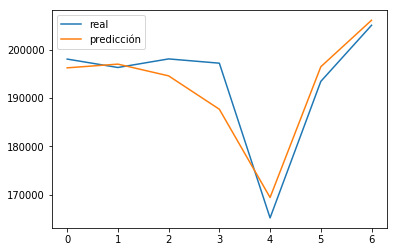

In [46]:
X=consumo1.drop(["fecha1","MWh"],axis=1)
y=consumo1.MWh

Xmax=X.max()
my=y.mean()
sy=y.std()

X_norm=X/Xmax
y_norm=(y-my)/sy

X_norm["gplearn1"]=np.cos(X_norm.day)*X_norm.num
X_norm["gplearn2"]=X_norm.num*X_norm["min"]
X_norm["gplearn3"]=3.319**X_norm["max"]*np.cos(X_norm.day)
X_norm["gplearn8"]=3.319**X_norm["max"]*X_norm.num 
X_norm["gplearn4"]=np.cos(X_norm.day)*np.sin(X_norm.day)
X_norm["gplearn5"]=X_norm.month*X_norm.Nubosidad*np.cos(X_norm.week)
X_norm["gplearn6"]=X_norm["max"]**2*X_norm["min"]**2
X_norm["gplearn7"]=1/np.cos(X_norm.day)
X_norm["gplearn9"]=X_norm["max"]**3*X_norm["min"]**2*np.cos(X_norm.week)**2
X_norm["gplearn10"]=X_norm["max"]*X_norm["min"]**3*np.cos(X_norm.month)**2

X_norm1=pd.get_dummies(X_norm,columns=["week","month","day"])

#X_norm1["inv1"]=datos.inv1.values
#X_norm1["inv2"]=datos.inv2.values
#X_norm1["prim"]=datos.prim.values
#X_norm1["ver"]=datos.ver.values
#X_norm1["oto1"]=datos.oto1.values
#X_norm1["oto2"]=datos.oto2.values

X_norm1=X_norm1.drop(["month_1.0","day_1.0","lluvia","eureka3","week_1.0"],axis=1)



X_train, X_test = X_norm1[:n].values, X_norm1[n:].values
y_train, y_test = y_norm[:n].values*sy+my,y_norm[n:].values*sy+my

reg = LinearRegression().fit(X_train, y_train)
y_predict=reg.predict(X_test)

plt.plot(y_test,label="real")
plt.plot(y_predict,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_predict,1))

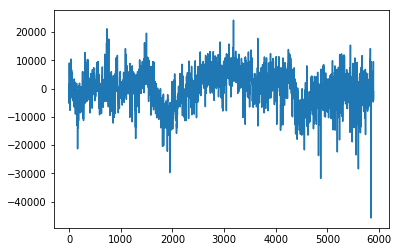

In [47]:
y_predict=reg.predict(X_norm1.values)
Tabla=pd.DataFrame(columns=['regresion','datos','resta'])
Tabla["regresion"]=y_predict
Tabla["datos"]=y_norm.values*sy+my
Tabla["resta"]=Tabla.datos-Tabla.regresion
plt.plot(Tabla.resta)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


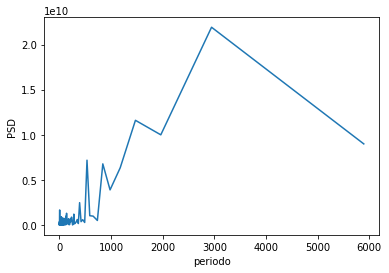

In [48]:
f, Pxx_den = signal.periodogram(Tabla.resta, 1)
plt.plot(1/f, Pxx_den)
plt.xlabel('periodo')
plt.ylabel('PSD')
plt.show()

In [49]:
top_50_periods = {}
# get indices for 3 highest Pxx values
top50_freq_indices = np.flip(np.argsort(Pxx_den), 0)[2:12]

freqs = f[top50_freq_indices]
power = Pxx_den[top50_freq_indices]
periods = 1 / np.array(freqs)
matrix=pd.DataFrame(columns=["power","periods"])
matrix.power=power
matrix.periods=periods

sencos = pd.DataFrame()
t = np.arange(1,len(consumo.MWh)+1)
sencos["t"]=np.arange(1,len(consumo.MWh)+1)
for i  in  matrix.periods:
        sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/i)*t))
        sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/i)*t))
sencos['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
sencos['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
sencos['sen1']=np.abs(np.sin(((2*np.pi)/365)*t))
sencos['cos1']=np.abs(np.cos(((2*np.pi)/365)*t))
sencos['sen2']=np.abs(np.sin(((2*np.pi)/28)*t))
sencos['cos2']=np.abs(np.cos(((2*np.pi)/28)*t))
sencos["fecha"]=consumo.fecha.copy()
sencos=sencos.set_index("fecha")

In [50]:
combination = pd.concat([X_norm1, sencos], axis=1)

In [120]:
n=-20

1.5780232907764695


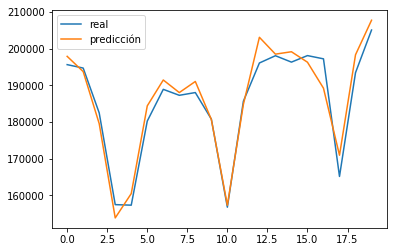

In [121]:
X_train, X_test = combination[:n].values, combination[n:].values
y_train, y_test = y_norm[:n].values*sy+my,y_norm[n:].values*sy+my

reg = LinearRegression().fit(X_train, y_train)
y_predict=reg.predict(X_test)

plt.plot(y_test,label="real")
plt.plot(y_predict,label="predicción")
plt.legend()
#plt.axis([0,6000,-3,3])
print(Mape(y_test,y_predict,1))

In [122]:
for a,b,c in zip(y_test,y_predict,y_norm[n:].index):
    print(Mape(a,b,1),c)

1.1525573413585777 2020-01-30 00:00:00
0.49335874577331384 2020-01-31 00:00:00
1.6002188874034717 2020-02-01 00:00:00
2.2983366270553653 2020-02-02 00:00:00
2.0042453597814136 2020-02-03 00:00:00
2.299050237750268 2020-02-04 00:00:00
1.3477258218882433 2020-02-05 00:00:00
0.39835135052346554 2020-02-06 00:00:00
1.6063576239859074 2020-02-07 00:00:00
0.048145980188483185 2020-02-08 00:00:00
0.3328758939581697 2020-02-09 00:00:00
0.4634061747566639 2020-02-10 00:00:00
3.5707455202343628 2020-02-11 00:00:00
0.21732516627792914 2020-02-12 00:00:00
1.4396601639344198 2020-02-13 00:00:00
0.9093119878076859 2020-02-14 00:00:00
4.052558874366087 2020-02-15 00:00:00
3.5003467670626556 2020-02-16 00:00:00
2.5242088553128603 2020-02-17 00:00:00
1.3016784361100442 2020-02-18 00:00:00


In [70]:
residuales=(y_train)-(reg.predict(X_train))
residuos=pd.DataFrame()
residuos["residuales"]=residuales
residuos["fecha"]=y_norm[:n].index.copy()
residuos=residuos.set_index("fecha")
result = seasonal_decompose(residuos, model='additive')

2.7136786457768767

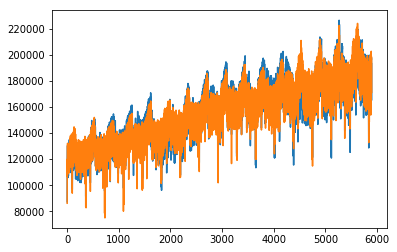

In [71]:
plt.plot(y_train)
plt.plot(reg.predict(X_train))
Mape(y_train,reg.predict(X_train),1)

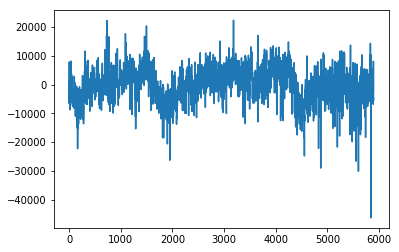

In [72]:
plt.plot(residuales)

## Bagging Regressor

### Con arbol de desición

In [123]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [124]:
regr = BaggingRegressor(DecisionTreeRegressor(),
                        n_estimators=300, random_state=0).fit(X_train, y_train)

0.9717632715013427

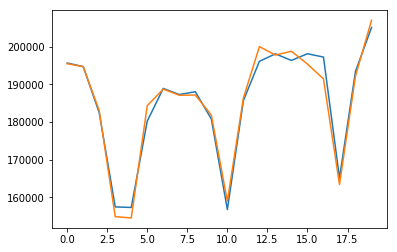

In [125]:
plt.plot(y_test)
plt.plot(regr.predict(X_test))
Mape(y_test,regr.predict(X_test),1)

In [126]:
for a,b,c in zip(y_test,regr.predict(X_test),y_norm[n:].index):
    print(Mape(a,b,1),c)

0.08995674529290996 2020-01-30 00:00:00
0.014262744392144509 2020-01-31 00:00:00
0.30518270940223635 2020-02-01 00:00:00
1.6456624197196994 2020-02-02 00:00:00
1.762410007252078 2020-02-03 00:00:00
2.258905203950629 2020-02-04 00:00:00
0.09838479084067421 2020-02-05 00:00:00
0.09888088995932416 2020-02-06 00:00:00
0.46516041101547667 2020-02-07 00:00:00
0.5800710627860065 2020-02-08 00:00:00
1.4111861762473878 2020-02-09 00:00:00
0.37636105490572136 2020-02-10 00:00:00
1.987460222792001 2020-02-11 00:00:00
0.15458589062774816 2020-02-12 00:00:00
1.2359993062772272 2020-02-13 00:00:00
1.3862213943408246 2020-02-14 00:00:00
2.9291959892807995 2020-02-15 00:00:00
1.0622910413303366 2020-02-16 00:00:00
0.6382905198991689 2020-02-17 00:00:00
0.9347968497144619 2020-02-18 00:00:00


0.7146494234254835

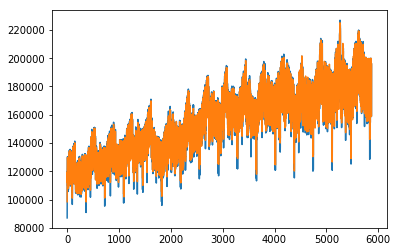

In [127]:
plt.plot(y_train)
plt.plot(regr.predict(X_train))
Mape(y_train,regr.predict(X_train),1)

## Adaboost

In [128]:
from sklearn.ensemble import AdaBoostRegressor

In [129]:
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                          n_estimators=400)
regr_2.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=400,
         random_state=None)

0.8178213640797686

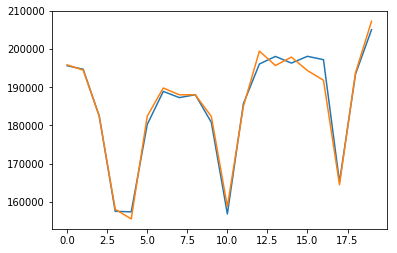

In [130]:
plt.plot(y_test)
plt.plot(regr_2.predict(X_test))
Mape(y_test,regr_2.predict(X_test),1)

In [131]:
for a,b,c in zip(y_test,y_predict,y_norm[n:].index):
    print(Mape(a,b,1),c)

1.1525573413585777 2020-01-30 00:00:00
0.49335874577331384 2020-01-31 00:00:00
1.6002188874034717 2020-02-01 00:00:00
2.2983366270553653 2020-02-02 00:00:00
2.0042453597814136 2020-02-03 00:00:00
2.299050237750268 2020-02-04 00:00:00
1.3477258218882433 2020-02-05 00:00:00
0.39835135052346554 2020-02-06 00:00:00
1.6063576239859074 2020-02-07 00:00:00
0.048145980188483185 2020-02-08 00:00:00
0.3328758939581697 2020-02-09 00:00:00
0.4634061747566639 2020-02-10 00:00:00
3.5707455202343628 2020-02-11 00:00:00
0.21732516627792914 2020-02-12 00:00:00
1.4396601639344198 2020-02-13 00:00:00
0.9093119878076859 2020-02-14 00:00:00
4.052558874366087 2020-02-15 00:00:00
3.5003467670626556 2020-02-16 00:00:00
2.5242088553128603 2020-02-17 00:00:00
1.3016784361100442 2020-02-18 00:00:00


0.031625158191895326

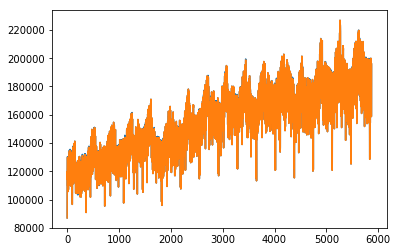

In [132]:
plt.plot(y_train)
plt.plot(regr_2.predict(X_train))
Mape(y_train,regr_2.predict(X_train),1)

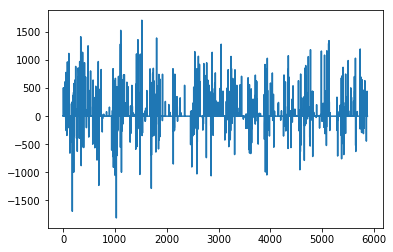

In [133]:
plt.plot(y_train-regr_2.predict(X_train))